En este notebook modificaremos y emplearemos una red de tipo nnU-Net para obtener un detector de lesiones medulares nuevas en pacientes con Esclerosis Múltiple.
Trabajaremos con un conjunto de imágenes FLAIR propio, que dividiremos en entrenamiento y pruebas. En este conjunto las imágenes vienen agrupadas en grupos de dos:
* Imagen basal: contiene la imagen del paciente.
* Imagen de seguimiento: contiene la imagen más reciente.
* Máscara de las lesiones: comprende el etiquetado final de la detección, de esta máscara tomaremos sólo las etiquetas marcadas con 2.

Las imágenes están en la carpeta lesiones de drive.


# 1. Descarga, análisis y pre-procesado de los datos 

## 1.1 Carga de librerias

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline 
try:
    import nibabel as nib #for loading data from NIfTI images
except:
    raise ImportError('Install NIBABEL')
from tqdm import tqdm
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from random import *
from skimage.io import imread
from glob import glob
from collections import OrderedDict
import json
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch

## 1.2. Conexión a Drive para la obtención de los datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Establecemos nuestra ruta
root_dir = "/content/drive/MyDrive"

base_dir = '/content/drive/MyDrive/Colab Notebooks'
os.chdir(base_dir)

# Listamos las imágenes
glob(os.path.join(root_dir,'lesiones','*'))

Mounted at /content/drive


NameError: ignored

## 1.3. Análisis visual de los datos
Agrupamos las imágenes y las máscaras en dos conjuntos para facilitar la división en conjuntos de entrenamiento y test. El conjunto de test será nuestro conjunto de validación, ya que nnU-Net dividirá el conjunto de entrenamiento en entrenamiento y test.

In [ ]:
# Dividimos las imágenes en máscaras e imágenes de entrenamiento. Tomaremos la imagen más reciente del paciente como baseline.
total_imagenes =sorted(glob(os.path.join(root_dir,'Lesiones','*')))
mascaras = list(filter(lambda x: x.find("mask") !=-1, total_imagenes)) 
img_basales = list(filter(lambda x:x.endswith("0000.nii.gz") , total_imagenes))
img_seguimiento = list(filter(lambda x:x.endswith("0001.nii.gz") , total_imagenes) )
# Mostramos el total de imágenes y las primeras imágenes de cada lista
print(len(total_imagenes),' matching files found:',img_basales[0], img_seguimiento[0], mascaras[0])
print("img_seguimiento:",len(img_seguimiento))
print("mascaras:",len(mascaras))

352  matching files found: /content/drive/MyDrive/Lesiones/FIS_001_01_0000.nii.gz /content/drive/MyDrive/Lesiones/FIS_001_01_0001.nii.gz /content/drive/MyDrive/Lesiones/FIS_001_mask_def.nii.gz
img_seguimiento: 117
mascaras: 117


Mostramos un ejemplo visual de las imágenes con las que vamos a trabajar.

Text(0.5, 1.0, 'Máscara')

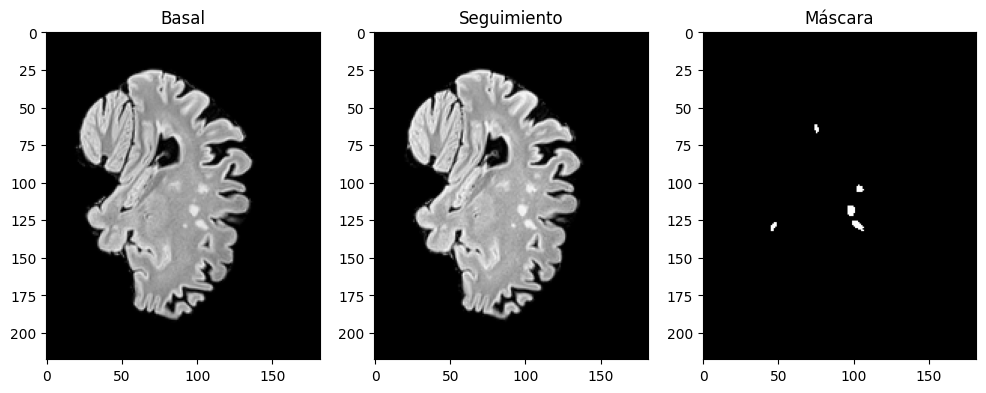

In [ ]:
# Mostramos unas imágenes al azar
x = randint(1, 117)
muestra_basal = nib.load(img_basales[x]).get_fdata()
muestra_seguimiento = nib.load(img_seguimiento[x]).get_fdata()
muestra_mascara = nib.load(mascaras[x]).get_fdata()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 6))
ax1.imshow(muestra_basal[muestra_basal.shape[0]//3],cmap='gray')
ax1.set_title('Basal')
ax2.imshow(muestra_seguimiento[muestra_seguimiento.shape[0]//3],cmap='gray')
ax2.set_title('Seguimiento')
ax3.imshow(muestra_mascara[muestra_mascara.shape[0]//3],cmap='gray')
ax3.set_title('Máscara')

# 2. Preparación y entrenamiento de nnU-Net

Aquí realizaremos los pasos necesarios para poder trabajar con el framework nnU-Net

## 2.1. Instalación de nnU-Net

Comenzamos instalando el framework.

In [ ]:
# Clonamos los datos de nnUNet para poder instalar
!git clone https://github.com/MIC-DKFZ/nnUNet.git

fatal: destination path 'nnUNet' already exists and is not an empty directory.


In [ ]:
# Declaramos el directorio raíz
nnunet_dir = '/content/drive/MyDrive/Colab Notebooks/nnUNet'
os.chdir(nnunet_dir)

In [ ]:
# Instalamos nnUNet
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/Colab%20Notebooks/nnUNet
  Preparing metadata (setup.py) ... done
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
  Attempting uninstall: nnunetv2
    Found existing installation: nnunetv2 2.1.1
    Uninstalling nnunetv2-2.1.1:
      Successfully uninstalled nnunetv2-2.1.1
  Running setup.py develop for nnunetv2


In [ ]:
# Instalamos hiddenlayer para que nos muestre la tipología de red que va generando
!pip install --upgrade git+https://github.com/julien-blanchon/hiddenlayer.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/julien-blanchon/hiddenlayer.git to /tmp/pip-req-build-h9z57b09
  Running command git clone --filter=blob:none --quiet https://github.com/julien-blanchon/hiddenlayer.git /tmp/pip-req-build-h9z57b09
  Resolved https://github.com/julien-blanchon/hiddenlayer.git to commit 8e14b20dbe9888630b07d70e2a55cf080b5bd5a9
  Preparing metadata (setup.py) ... done


## 2.2. Preparación del dataset dividiéndolo en imágenes y etiquetas para nnU-Net

Crearemos una estructura de carpetas adecuada a las necesidades de nnU-Net

In [ ]:
# Creamos la función para crear directorios si no existen
def make_if_dont_exist(folder_path,overwrite=False):    
    if os.path.exists(folder_path):
        # Si existe lo indicamos
        if not overwrite:
            print(f"{folder_path} exists.")
        else:
            print(f"{folder_path} overwritten")
            shutil.rmtree(folder_path)
            os.makedirs(folder_path)

    else:
      # No existe creamos el directorio
      os.makedirs(folder_path)
      print(f"{folder_path} created!")
# Creamos la estructura de carpetas y distribuimos las imágenes
task_name = 'Dataset103_SLEM'
nnunet_dir = "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data"
task_folder_name = os.path.join(nnunet_dir,task_name)
img_dir = '/content/drive/MyDrive/Lesiones'
# Creamos los directorios
make_if_dont_exist(task_folder_name+"/imagesTr",overwrite=False)
make_if_dont_exist(task_folder_name+"/imagesTs",overwrite=False)
make_if_dont_exist(task_folder_name+"/labelsTr",overwrite=False)
make_if_dont_exist(task_folder_name+"/labelsTs",overwrite=False)

train_image_dir = os.path.join(task_folder_name,'imagesTr')
train_label_dir = os.path.join(task_folder_name,'labelsTr')

test_image_dir = os.path.join(task_folder_name,'imagesTs')
test_label_dir = os.path.join(task_folder_name,'labelsTs')

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset103_SLEM/imagesTr exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset103_SLEM/imagesTs exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset103_SLEM/labelsTr exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset103_SLEM/labelsTs exists.


Tenemos 117 grupos de 3 imágenes cada uno (una imagen basal, una imagen actual y la etiqueta con la segmentación). Debemos dividir estas imágenes en conjuntos de entrenamiento y test. Aunque nnU-Net hace su propia división para entrenar los modelos, es interesante tener un conjunto para probar el rendimiento y comparar predicciones. Haremos una división 80%-20% para train y test. Transformaremos las máscaras dejando sólo la clase 2.

In [ ]:
def copia_imagenes(origen, img_dir, image_dir, label_dir):
   ruta, file = os.path.split(origen)
   if file.endswith('.nii.gz'):
        # En ambos casos vamos a renombrar, tomamos el nombre original
        original_name = os.path.join(img_dir, file)

        # Separamos la base y la extensión
        base, extension = os.path.splitext(file)
        
        if file.find('mask')!=-1:
            # Tenemos una máscara, la renombramos para que el framework la reconozca
            # quitando '_mask_def' y quitamos las etiquetas 1, dejando sólo la 2
            original = nib.load(origen)
            elem = original.get_fdata()
            elem[elem == 1] = 0
            elem[elem == 2] = 1
            new_img = nib.Nifti1Image(elem, affine=original.affine, header=original.header)
            
            nueva_base = base.replace('_mask_def','')
            nueva_ruta = os.path.join(label_dir,nueva_base + extension)
            nib.save(new_img, nueva_ruta)  
        else:
            # Aquí también nos toca renombrar, vamos a quitar el _01_ 
            # central común a todas las imágenes
            nueva_base = base.replace('_01_','_')
            nueva_ruta = os.path.join(image_dir,nueva_base + extension)
            shutil.copy(os.path.join(img_dir,file),nueva_ruta)

# Vamos a hacer la división de forma manual
cantidad_tr = 94
cantidad_ts = 23
i = 0
while i < 117:
  x = randint(0, 10)
  if ( x > 5 and cantidad_ts > 0):
    image_dir = test_image_dir
    label_dir = test_label_dir
    cantidad_ts = cantidad_ts-1
  else:
    image_dir = train_image_dir
    label_dir = train_label_dir

  # Tomamos el archivo
  img_basal = img_basales[i]
  img_segto = img_seguimiento[i]
  etiqueta = mascaras[i]

  copia_imagenes(img_basal, img_dir,image_dir,label_dir)
  copia_imagenes(img_segto, img_dir,image_dir,label_dir)
  copia_imagenes(etiqueta, img_dir,image_dir,label_dir)
  # Incrementamos i
  i = i+1
  

Verificamos que la copia de los datos fue correcta

In [ ]:
train_files = os.listdir(train_image_dir)
label_files = os.listdir(train_label_dir)
print("train image files:",len(train_files))
print("train label files:",len(label_files))
print("Matches:",len(set(train_files).intersection(set(label_files))))

test_files = os.listdir(test_image_dir)
label_tfiles = os.listdir(test_label_dir)
print("test image files:",len(test_files))
print("test label files:",len(label_tfiles))

train image files: 188
train label files: 94
Matches: 0
test image files: 46
test label files: 23


Mostramos imágenes y etiquetas para ver que todo se hizo bien

Text(0.5, 1.0, 'Máscara')

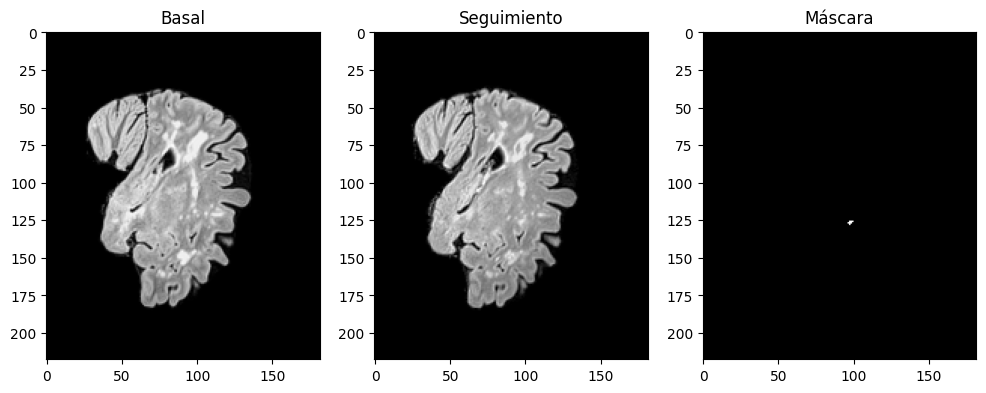

In [ ]:
# Mostramos unas imágenes al azar
x = 0
ruta_img = '/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset103_SLEM/imagesTr'
ruta_lbl = '/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset103_SLEM/labelsTr'
muestra_basal = nib.load(os.path.join(ruta_img, train_files[x])).get_fdata()
muestra_seg = nib.load(os.path.join(ruta_img, train_files[x+1])).get_fdata()
muestra_mascara = nib.load(os.path.join(ruta_lbl, label_files[x])).get_fdata()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 6))
ax1.imshow(muestra_basal[muestra_basal.shape[0]//3], cmap='gray')
ax1.set_title('Basal')
ax2.imshow(muestra_seg[muestra_seg.shape[0]//3], cmap='gray')
ax2.set_title('Seguimiento')
ax3.imshow(muestra_mascara[muestra_mascara.shape[0]//3], cmap='gray')
ax3.set_title('Máscara')

## 2.3 Configuración de nnU-Net

Ahora vamos a configurar nnU-Net para que se adapte a nuestro dataset

In [ ]:
overwrite_json_file = True #make it True if you want to overwrite the dataset.json file in Task_folder
json_file_exist = False

if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
    print('dataset.json already exist!')
    json_file_exist = True

if json_file_exist==False or overwrite_json_file:

    json_dict = OrderedDict()
    json_dict['name'] = task_name    

    #you may mention more than one modality
    json_dict['channel_names'] = {
        "0": "FLAIR",
        "1": "T1"
    }

    #labels+1 should be mentioned for all the labels in the dataset
    json_dict['labels'] = {
        "background": 0,
        "New_or_changing_lesions": 1
    }
    
    train_ids = os.listdir(train_label_dir)
    test_ids = os.listdir(test_label_dir)
    json_dict['numTraining'] = len(train_ids)
    json_dict['numTest'] = len(test_ids)
    json_dict['training'] = [{'image': "./imagesTr/%s" % i, "label": "./labelsTr/%s" % i} for i in train_ids]
    json_dict['test'] = ["./imagesTs/%s" % i for i in test_ids]

    json_dict['file_ending'] = ".nii.gz"


    with open(os.path.join(task_folder_name,"dataset.json"), 'w') as f:
        json.dump(json_dict, f, indent=4, sort_keys=False)

    if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
        if json_file_exist==False:
            print('dataset.json created!')
        else: 
            print('dataset.json overwritten!')

dataset.json already exist!
dataset.json overwritten!


Creación de variables de entorno

In [ ]:
# Vamos a crear las variables de entorno
mount_dir = '/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2'
print("Current Working Directory {}".format(os.getcwd()))
path_dict = {
    "nnUNet_raw" : os.path.join(mount_dir, "nnUNet_raw_data_base/nnUNet_raw_data"), 
    "nnUNet_preprocessed" : os.path.join(mount_dir, "nnUNet_preprocessed"),
    "nnUNet_results" : os.path.join(mount_dir, "nnUNet_Results_Folder"),
}

# Write paths to environment variables
for env_var, path in path_dict.items():
  os.environ[env_var] = path 

# Check whether all environment variables are set correct!
for env_var, path in path_dict.items():
  if os.getenv(env_var) != path:
    print("Error:")
    print("Environment Variable {} is not set correctly!".format(env_var))
    print("Should be {}".format(path))
    print("Variable is {}".format(os.getenv(env_var)))
  make_if_dont_exist(path, overwrite=False)

print("If No Error Occured Continue Forward. =)")

!export nnUNet_raw=os.path.join(mount_dir, "nnUNet_raw_data_base/nnUNet_raw_data")
!export nnUNet_preprocessed=os.path.join(mount_dir, "nnUNet_preprocessed")
!export nnUNet_results=os.path.join(mount_dir, "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder")

Current Working Directory /content/drive/MyDrive/Colab Notebooks/nnUNet
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_preprocessed exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder exists.
If No Error Occured Continue Forward. =)
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `export nnUNet_raw=os.path.join(mount_dir, "nnUNet_raw_data_base/nnUNet_raw_data")'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `export nnUNet_preprocessed=os.path.join(mount_dir, "nnUNet_preprocessed")'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `export nnUNet_results=os.path.join(mount_dir, "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder")'


# 2.4. Verificación del dataset por parte de nnU-Net

In [ ]:
#running it from the experiment_planning folder to verify the path settings
main_dir = os.path.join(base_dir,'nnUNet/nnunetv2')
os.chdir(main_dir)
!nnUNetv2_plan_and_preprocess -d 103 --verify_dataset_integrity
os.chdir(main_dir)

Fingerprint extraction...
Dataset103_SLEM
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer

####################
verify_dataset_integrity Done. 
If you didn't see any error messages then your dataset is most likely OK!
####################

Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer
100% 94/94 [00:46<00:00,  2.02it/s]
Experiment planning...
2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 76, 'patch_size': array([224, 192]), 'median_image_size_in_voxels': array([218., 182.]), 'spacing': array([1., 1.]), 'normalization_schemes': ['ZScoreNormalization', 'ZScoreNormalization'], 'use_mask_for_norm': [False, False], 'UNet_class_name': 'PlainConvUNet', 'UNet_base_num_features': 32, 'n_conv_per_stage_encoder': (2, 2, 2, 2, 2, 2), 'n_conv_per_stage_decoder': (2, 2, 2, 2, 2), 'num_pool_per_axis': [5, 5], 'pool_op_kernel_sizes': [[1, 1], [2, 2], [

## 2.5. Entrenamiento de nnU-Net

Ya tenemos todo listo para proceder con el entrenamiento de la red para segmentar nuevas lesiones.

In [ ]:
!nnUNetv2_train 103 3d_fullres 0 --c -tr nnUNetTrainer_100epochsCheck --npz

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################


This is the configuration used by this training:
Configuration name: 3d_fullres
 {'data_identifier': 'nnUNetPlans_3d_fullres', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 2, 'patch_size': [128, 128, 128], 'median_image_size_in_voxels': [182.0, 218.0, 182.0], 'spacing': [1.0, 1.0, 1.0], 'normalization_schemes': ['ZScoreNormalization', 'ZScoreNormalization'], 'use_mask_for_norm': [False, False], 'UNet_class_name': 'PlainConvUNet', 'UNet_base_num_features': 32, 'n_conv_per_stage_encoder': [2, 2, 2, 2, 2, 2], 'n_conv_per_stage_decoder': [2, 2, 2, 2, 2], 'num_